# Tarea 2.
Para ejemplo estudiado en esta clase data WWWUsage.csv probar lo siguiente:

1. Encontrar el mejor modelo ARIMA usando los criterios de AIC, BIC y log-verosimilud, justificando la estructura propuesta.
2. Analizar el efecto de normalizar la serie de tiempo, es decir usar MinMaxScaler para normalizar los datos. Posterior a esto, realizar el mismo precedimiento realizado en clase y encontrar el mejor modelo de ARIMA. Justifique todos los análisis realizados, incluyendo los resultados de las gráficas de ACF y PAC.
3. Investigar la implementación y teoría de los modelos SARIMAX. Además de eso, generar un modelo de pronóstico usando SARIMAX, donde todo el procediemiento anteriormente descrito es implementado, para el siguiente conjunto de datos con estacionalidad:
```
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))
data2.index = pd.date_range(start=datetime(data2.time[0], 1, 1), periods=len(data2), freq='MS')
```
Nota: Pueden basarse en el siguiente enlace para entender el análisis a realizar https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

4. Realizar una predicción de 20 unidades de tiempo en el futuro, tanto para el modelo ARIMA como SARIMA y reportar los resulados en una gráfica donde se puedan observar los datos reales y los datos predichos, cómo en la siguiente gráfica:

In [1]:
# Importamos las librerías
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pandas.tseries.offsets import DateOffset
import requests
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from io import BytesIO
import warnings
warnings.filterwarnings("ignore")

In [2]:
# El horizonte de predicción que se desea con el modelo
HORIZONTE = 20

def split_dataset(data):
    """
    Función que se encarga de dividir la data ingresada en datos de entrenamiento y prueba.
    :param data: Data con la información de la serie de tiempo a analizar.
    """

    train_data, test_data = train_test_split(data, test_size=0.2, random_state=0, shuffle=False)

    return train_data, test_data

def evaluate_forecasts(actual, predicted):
    """
    Función que se encargará de calcular las métricas de error. (MSE, RMSE, MAD, MAPE)
    :param actual: Valor actual de la serie de tiempo que se desea predecir.
    :param predicted: Valor predecido por el modelo ajustado.
    """
    mse = mean_squared_error(actual, predicted)
    rmse = mean_squared_error(actual, predicted, squared=True)
    mad = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted)

    return mse, rmse, mad, mape

def model_forecast(history, data, p, d, q, start, end, horizonte=0):
    """
    Función que entrena y predice con el modelo entrenado un horizonte de tiempo HORIZONTE.
    :param history: Serie de tiempo con el cuál se entrenará el modelo. El tipo de dato tiene que estar acorde con el tipo de datos que reciba el modelo.
    """
    # Modelo de ARIMA
    arima_model = ARIMA(history, order=(p, d, q))
    model = arima_model.fit()
    print(model.summary())

    # Gráfico de los diagnósticos para los residuos
    plt.figure(figsize=(7,7))
    model.plot_diagnostics()
    plt.show()

    # Cómo realizar predicciones con el modelo ajustado
    model_func = model.predict(start=start, end=end + horizonte, dynamic=False).to_frame()
    ax = data.plot()
    model_func.plot(ax=ax)

    return model_func

def evaluate_model(model_func, train, test):
    """
    Función que se encargará de evaluar el modelo y calcular las métricas de error.
    :param model_func: Función del modelo que se encarga de entrenar y predecir un horizonte
                       de tiempo HORIZONTE.
    :param train: Datos de entrenamiento.
    :param test: Datos de prueba.
    """

## ARIMA

### Ejercicio 1
Encontrar el mejor modelo ARIMA usando los criterios de AIC, BIC y log-verosimilud, justificando la estructura propuesta.

In [3]:
df = pd.read_csv("/Users/rosaura/Downloads/WWWusage.csv")
df.drop(columns=["time", "Unnamed: 0"], inplace=True)
df

,WWWusage
0,88
1,84
2,85
3,85
4,84
...,...
95,222
96,228
97,226
98,222


<AxesSubplot:>

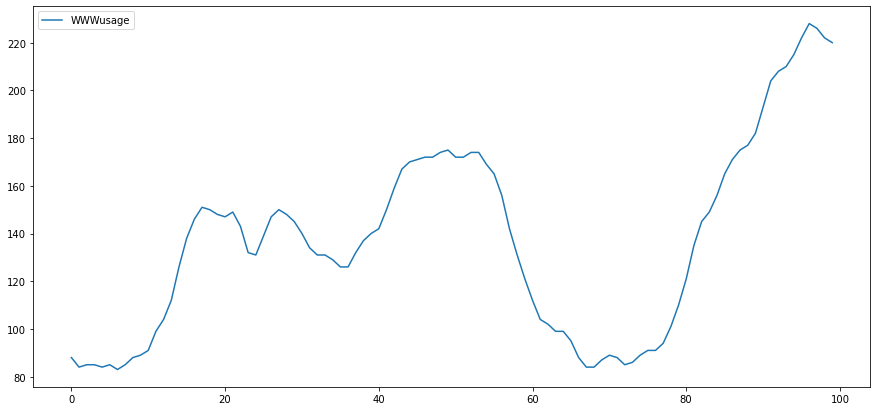

In [4]:
# Visualización de la serie de tiempo
df.plot(figsize=(15,7))

In [5]:
# 1. Graficar ACF y PACF
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()

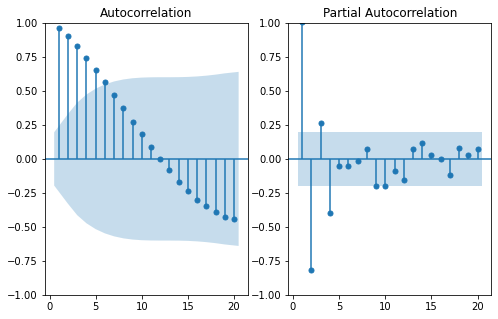

In [6]:
plot_acf_pacf(df)

En la gráfica ACF se observa que la autocorrelación no se va atenuando. No hay AR ni MA.

In [7]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [8]:
adf_test(df)

Results of Dickey-Fuller Test:
Test Statistic                 -2.464240
p-value                         0.124419
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


El p-value es mayor a 0.05, no se rechaza la hipótesis nula y por lo tanto, la seire no es estacionaria. Hay que diferenciarla.

In [9]:
# Primera diferenciación
diff1_values = df.diff().dropna()

print('ADF para derivada primer orden...\n')
adf_test(diff1_values)

ADF para derivada primer orden...

Results of Dickey-Fuller Test:
Test Statistic                 -2.722238
p-value                         0.070268
#Lags Used                      2.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


Ahora el p-value es muy cercano a 0.05, podemos elegir si rechazamos o no la hipótesis nula.

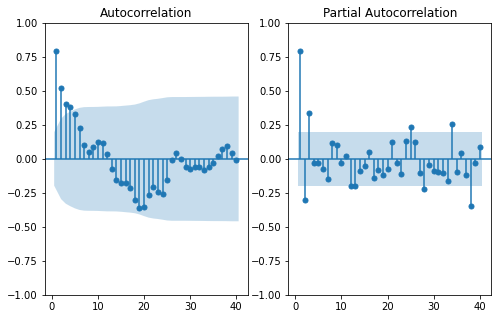

In [10]:
plot_acf_pacf(diff1_values, {'lags':40})

+ Ahora la autocorrelación tiene un comportamiento senoidal, yo podría Q = 4.
+ La gráfica PACF nos indica que P = 3.

In [11]:
# Train test split 80% datos de entrenamiento y 20% datos de prueba.
train_data, test_data = split_dataset(df)

In [12]:
train_data

,WWWusage
0,88
1,84
2,85
3,85
4,84
...,...
75,91
76,91
77,94
78,101


In [13]:
test_data

,WWWusage
80,121
81,135
82,145
83,149
84,156
85,165
86,171
87,175
88,177
89,182


                               SARIMAX Results                                
Dep. Variable:               WWWusage   No. Observations:                   80
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -200.168
Date:                Tue, 07 Feb 2023   AIC                            416.336
Time:                        11:25:51   BIC                            435.291
Sample:                             0   HQIC                           423.930
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5070      0.285      5.288      0.000       0.948       2.066
ar.L2         -1.0519      0.458     -2.297      0.022      -1.949      -0.154
ar.L3          0.1711      0.291      0.587      0.5

<Figure size 504x504 with 0 Axes>

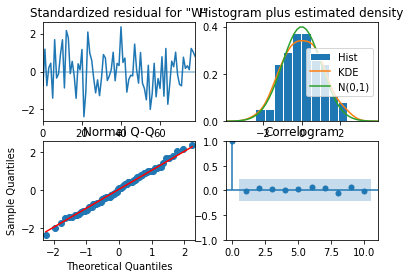

,predicted_mean
81,122.874804
82,127.118475
83,129.883441
84,130.529289
85,129.320116
86,127.291519
87,125.616804
88,125.019994
89,125.535178
90,126.652849


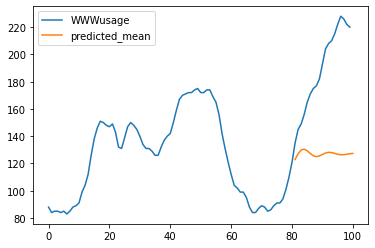

In [14]:
# Forecast
model_func = model_forecast(train_data, df, 3,1,4, start=81, end=100)
model_func

- Los residuos presentan una distribución normal.

In [15]:
# Métricas de evaluación
mse, rmse, mad, mape = evaluate_forecasts(test_data, model_func)
results = pd.DataFrame([mse, rmse, mad, mape]).T
results.columns = ["mse", "rmse", "mad", "mape"]
results

,mse,rmse,mad,mape
0,4547.139452,4547.139452,59.28842,0.295474


Este modelo fue muy malo, las métricas de error son muy altas. En la gráfica podemos observar que los valores de la predicción fueron mucho más bajos que los valores reales.

In [16]:
# Diferenciación de 2
diff2_values = df.diff().diff().dropna()

print('ADF para derivada segundo orden...\n')
adf_test(diff2_values)

ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -9.929762e+00
p-value                        2.843429e-17
#Lags Used                     1.000000e+00
Number of Observations Used    9.600000e+01
Critical Value (1%)           -3.500379e+00
Critical Value (5%)           -2.892152e+00
Critical Value (10%)          -2.583100e+00
dtype: float64
Stationary


Ahoa sí estamos seguros de que la serie es estacionaria, rechazamos la hipótesis nula.

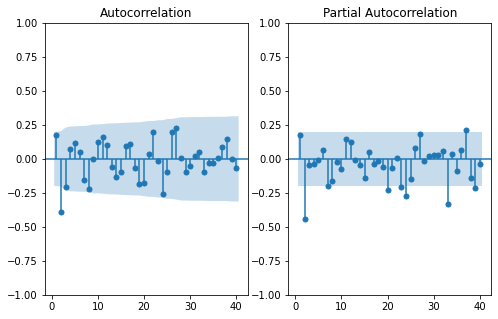

In [17]:
plot_acf_pacf(diff2_values, {'lags':40})

La gráfica ACF nos indica que Q debe ser de 2, y PACF nos indica que P debe ser 2 también. Además, ya sabemos que D = 2 porque con una segunda diferenciación convertimos la serie a estacionaria.

                               SARIMAX Results                                
Dep. Variable:               WWWusage   No. Observations:                   80
Model:             ARIMA([2], 2, [2])   Log Likelihood                -204.918
Date:                Tue, 07 Feb 2023   AIC                            415.836
Time:                        11:25:52   BIC                            422.906
Sample:                             0   HQIC                           418.666
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.1580      0.299     -0.528      0.598      -0.744       0.428
ma.L2         -0.2139      0.299     -0.716      0.474      -0.799       0.372
sigma2        11.1660      2.019      5.531      0.0

<Figure size 504x504 with 0 Axes>

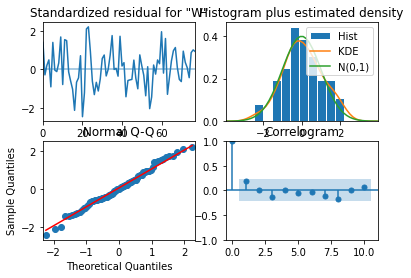

,predicted_mean
81,124.312021
82,131.192974
83,138.228424
84,145.230071
85,152.207315
86,159.189898
87,166.176336
88,173.161931
89,180.146916
90,187.132035


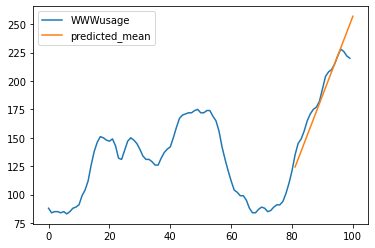

In [18]:
# Modelo 2
model_func2 = model_forecast(train_data, df, (0,1),2,(0,1), start=81, end=100) # Hiperparámetros usados en clase
model_func2

- Los residuos están distribuidos casi de forma normal, hay un ligero sesgo a la derecha.

In [19]:
# Métricas de evaluación
mse, rmse, mad, mape = evaluate_forecasts(test_data, model_func2)
results2 = pd.DataFrame([mse, rmse, mad, mape]).T
results2.columns = ["mse", "rmse", "mad", "mape"]
results2

,mse,rmse,mad,mape
0,141.850904,141.850904,7.775247,0.039282


Ahora las métricas de error son mucho más pequeñas, lo que nos indica que el modelo fue mejor. Además, en la gráfica podemos ver que la predicción fue más cercana a los valores reales, pero nuestra predicción fue lineal.

                               SARIMAX Results                                
Dep. Variable:               WWWusage   No. Observations:                   80
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -202.613
Date:                Tue, 07 Feb 2023   AIC                            415.225
Time:                        11:25:53   BIC                            427.009
Sample:                             0   HQIC                           419.943
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4506      0.289      1.562      0.118      -0.115       1.016
ar.L2         -0.2584      0.262     -0.985      0.325      -0.772       0.256
ma.L1         -0.2520      0.294     -0.857      0.3

<Figure size 504x504 with 0 Axes>

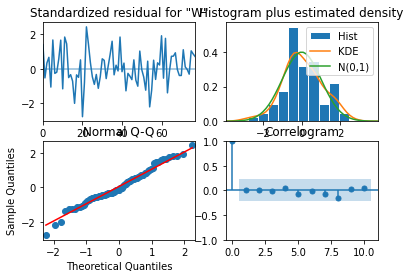

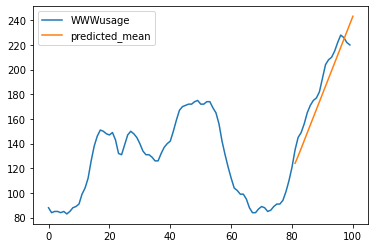

In [20]:
# Modelo 3: cambio de hiperparámetros
model_func3 = model_forecast(train_data, df, 2,2,2, start=81, end=100)

In [21]:
# Métricas de evaluación
mse, rmse, mad, mape = evaluate_forecasts(test_data, model_func3)
results3 = pd.DataFrame([mse, rmse, mad, mape]).T
results3.columns = ["mse", "rmse", "mad", "mape"]
results3

,mse,rmse,mad,mape
0,77.954,77.954,7.361961,0.039742


En este nuevo modelo logré bajar el mse de 141 a 77, lo que nos indica que los valores de P y Q que habíamos decidido usar sí dieron buenos resultados.
+ La distribución de los residuos tiene un sesgo a la derecha.

In [22]:
results_ej1 = pd.concat([results, results2, results3])
results_ej1.index = ["Modelo1", "Modelo2", "Modelo3"]
results_ej1

,mse,rmse,mad,mape
Modelo1,4547.139452,4547.139452,59.288420,0.295474
Modelo2,141.850904,141.850904,7.775247,0.039282
Modelo3,77.954000,77.954000,7.361961,0.039742


Si consideramos el MSE, el modelo 3 fue el que tuvo mejores predicciones, pero si tomamos en ceunta el mape el mejor modelo fue el segundo.,

### Ejercicio 2
Analizar el efecto de normalizar la serie de tiempo, es decir usar MinMaxScaler para normalizar los datos. Posterior a esto, realizar el mismo precedimiento realizado en clase y encontrar el mejor modelo de ARIMA. Justifique todos los análisis realizados, incluyendo los resultados de las gráficas de ACF y PAC.

In [23]:
# Se normaliza la variable WWWUsage
scaler = MinMaxScaler()
scaler.fit(df)
df_normalized = scaler.transform(df)
df_normalized = pd.DataFrame(df_normalized, columns=["WWWUsage"])
df_normalized

,WWWUsage
0,0.034483
1,0.006897
2,0.013793
3,0.013793
4,0.006897
...,...
95,0.958621
96,1.000000
97,0.986207
98,0.958621


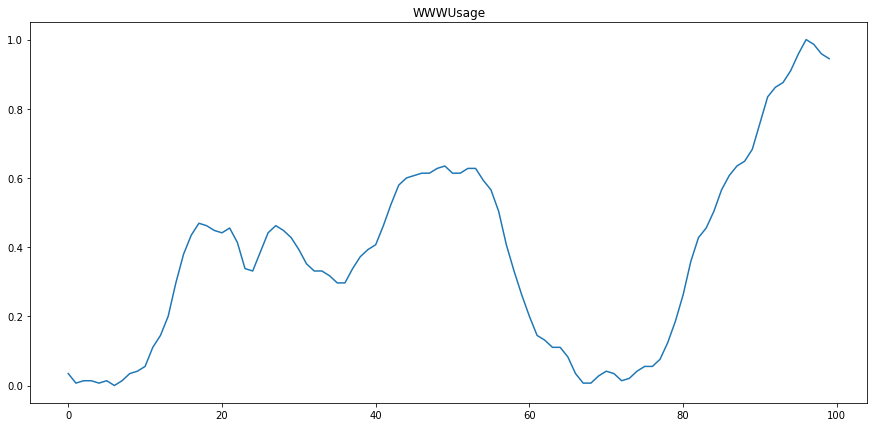

In [24]:
# Visualización de la serie de tiempo
plt.figure(figsize=(15,7))
plt.plot(df_normalized)
plt.title("WWWUsage")
plt.show()

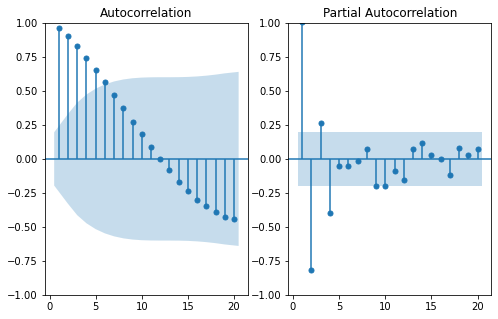

In [25]:
plot_acf_pacf(df_normalized)

Las gráficas se ven muy similares a los datos sin normalizar. Se puede observar que el primer lag también llega a uno.

In [26]:
adf_test(df_normalized)

Results of Dickey-Fuller Test:
Test Statistic                 -2.464240
p-value                         0.124419
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


El p-value está muy lejano a 0.05, es igual a como se ve en los datos originales. Se debe de diferenciar.

In [27]:
diff1_normalized = df_normalized.diff().dropna()

print('ADF para derivada primer orden...\n')
adf_test(diff1_normalized)

ADF para derivada primer orden...

Results of Dickey-Fuller Test:
Test Statistic                 -2.722238
p-value                         0.070268
#Lags Used                      2.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


Como no podemos rechazar la hipótesis nula se hace una segunda diferenciación.

In [28]:
diff2_normalized = df_normalized.diff().diff().dropna()

print('ADF para derivada segundo orden...\n')
adf_test(diff2_normalized)

ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -9.929762e+00
p-value                        2.843429e-17
#Lags Used                     1.000000e+00
Number of Observations Used    9.600000e+01
Critical Value (1%)           -3.500379e+00
Critical Value (5%)           -2.892152e+00
Critical Value (10%)          -2.583100e+00
dtype: float64
Stationary


Ahora sí podemos rechazar la hipótesis nula y confirmar que la serie es estacionaria. Hasta ahora los resultados han sido igual que en el ejercicio 1.

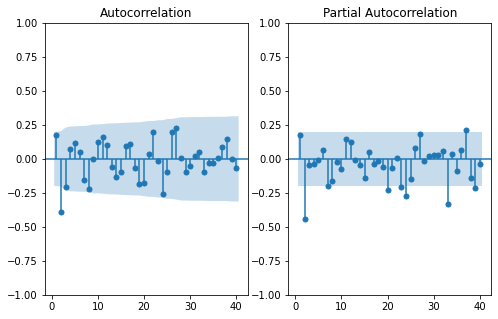

In [29]:
plot_acf_pacf(diff2_normalized, {'lags':40})

Al igual que con los datos originales, las gráficas nos indican que P y Q deben ser 2.

In [30]:
# Train test split
train_data_normalized, test_data_normalized = split_dataset(df_normalized)

                               SARIMAX Results                                
Dep. Variable:               WWWUsage   No. Observations:                   80
Model:             ARIMA([2], 2, [2])   Log Likelihood                 183.267
Date:                Tue, 07 Feb 2023   AIC                           -360.535
Time:                        11:25:56   BIC                           -353.464
Sample:                             0   HQIC                          -357.704
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.1567      0.299     -0.523      0.601      -0.744       0.430
ma.L2         -0.2148      0.299     -0.719      0.472      -0.800       0.371
sigma2         0.0005   9.59e-05      5.534      0.0

<Figure size 504x504 with 0 Axes>

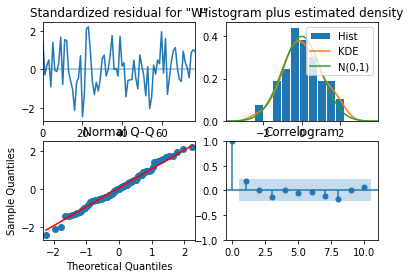

,predicted_mean
81,0.284931
82,0.332382
83,0.380891
84,0.429170
85,0.477284
86,0.525433
87,0.573609
88,0.621779
89,0.669945
90,0.718111


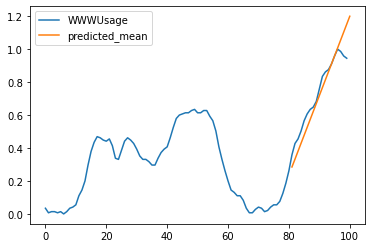

In [31]:
model_func4 = model_forecast(train_data_normalized, df_normalized, (0,1),2,(0,1), start=81, end=100)
model_func4

In [32]:
# Métricas de evaluación
mse, rmse, mad, mape = evaluate_forecasts(test_data_normalized, model_func4)
results4 = pd.DataFrame([mse, rmse, mad, mape]).T
results4.columns = ["mse", "rmse", "mad", "mape"]
results4

,mse,rmse,mad,mape
0,0.00674,0.00674,0.053589,0.071679


La gráfica de la predicción se ve igual pero las métricas de error son considerablemente más bajos. Si nos basáramos solamente en las métricas pensaríamos que el modelo es mucho más preciso.
+ La distribución de los residuos tiene un ligero sesgo a la derecha.

## SARIMAX

### Ejercicio 3
Investigar la implementación y teoría de los modelos SARIMAX. Además de eso, generar un modelo de pronóstico usando SARIMAX, donde todo el procediemiento anteriormente descrito es implementado, para el siguiente conjunto de datos con estacionalidad:
```
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))
data2.index = pd.date_range(start=datetime(data2.time[0], 1, 1), periods=len(data2), freq='MS')
```
Nota: Pueden basarse en el siguiente enlace para entender el análisis a realizar https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

In [33]:
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data = pd.read_stata(BytesIO(air2))
data.index = pd.date_range(start=datetime.datetime(data.time[0], 1, 1), periods=len(data), freq='MS') # month start frequency
data

,air,time,t
1949-01-01,112,1949.000000,1.0
1949-02-01,118,1949.083374,2.0
1949-03-01,132,1949.166626,3.0
1949-04-01,129,1949.250000,4.0
1949-05-01,121,1949.333374,5.0
...,...,...,...
1960-08-01,606,1960.583374,140.0
1960-09-01,508,1960.666626,141.0
1960-10-01,461,1960.750000,142.0
1960-11-01,390,1960.833374,143.0


Este conjunto de datos proporciona totales mensuales de pasajeros de una aerolínea de EE. UU. desde 1949 hasta 1960.

In [34]:
# Eliminamos las variables que no necesitamos
data = data.drop(columns=["time", "t"])
data

,air
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390


<AxesSubplot:>

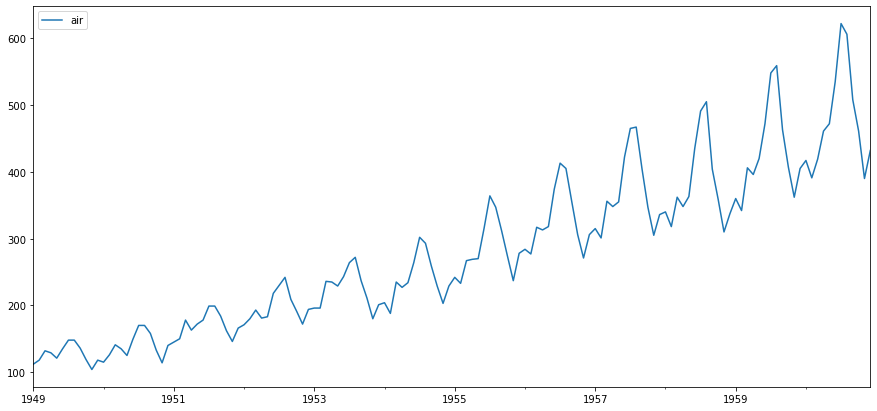

In [35]:
# Visualización de la serie de tiempo
data.plot(figsize=(15,7))

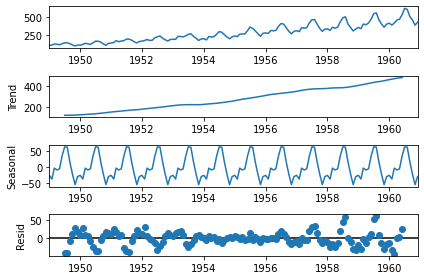

In [36]:
# Descomposición estacional de la serie de tiempo
decompose_data = seasonal_decompose(data, model="additive", period=12)
decompose_data.plot();

- Confirmamos que tiene una tendencia a la alta, rango de 200 a 400.
- El rango de la estacionalidad va de -50 a 50.
- Los residuos se acercan a cero.

<AxesSubplot:>

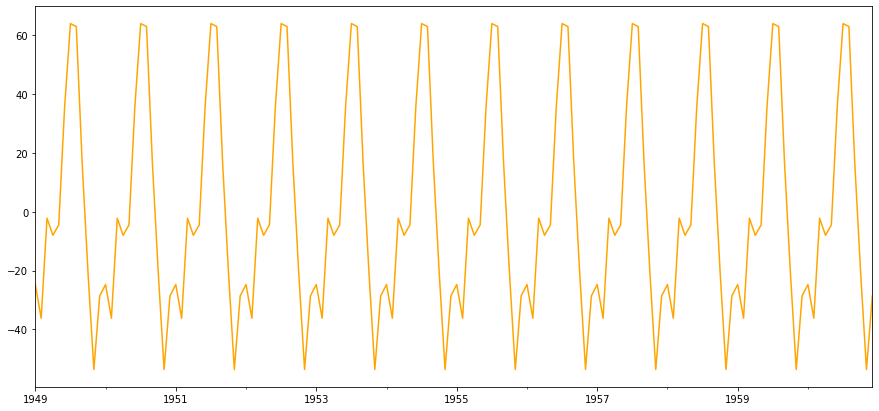

In [37]:
# Extracción de la estacionalidad
seasonality=decompose_data.seasonal
seasonality.plot(color='orange', figsize=(15,7))

In [38]:
adf_test(data)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
Non-stationary


El p-value está muy alejado de 0.05, por eso no se rechaza la hipótesis nula. La serie no es estacionaria.

El artículo menciona que a menudo, con los datos en los que el efecto de la estacionalidad es excesivo, se utiliza la diferencia de media móvil.

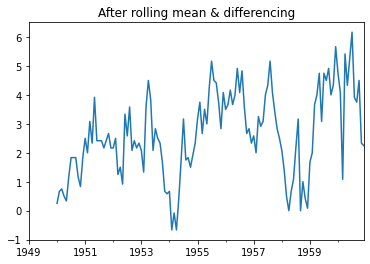

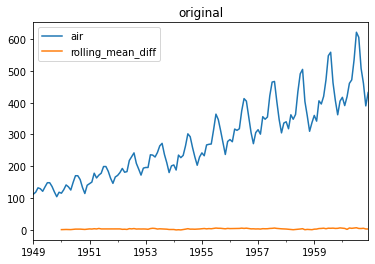

In [39]:
# Diferenciación
rolling_mean = data.rolling(window = 12).mean()
data['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
data['rolling_mean_diff'].plot(title='After rolling mean & differencing');
ax2 = plt.subplot()
data.plot(title='original');

In [40]:
data

,air,rolling_mean_diff
1949-01-01,112,NaN
1949-02-01,118,NaN
1949-03-01,132,NaN
1949-04-01,129,NaN
1949-05-01,121,NaN
...,...,...
1960-08-01,606,3.916667
1960-09-01,508,3.750000
1960-10-01,461,4.500000
1960-11-01,390,2.333333


Podemos ver que se ha reducido mucho la estacionalidad.

In [41]:
adf_test(data["rolling_mean_diff"].dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -3.383021
p-value                          0.011551
#Lags Used                       1.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
Stationary


Ahora la serie sí es estacionaria, el p-value es menor a 0.05 y se rechaza la hipótesis nula.

In [57]:
# Train test split
train_data2, test_data2 = split_dataset(data)
train_data2

,air,rolling_mean_diff
1949-01-01,112,NaN
1949-02-01,118,NaN
1949-03-01,132,NaN
1949-04-01,129,NaN
1949-05-01,121,NaN
...,...,...
1958-03-01,362,0.500000
1958-04-01,348,0.000000
1958-05-01,363,0.666667
1958-06-01,435,1.083333


In [58]:
test_data2

,air,rolling_mean_diff
1958-08-01,505,3.166667
1958-09-01,404,0.000000
1958-10-01,359,1.000000
1958-11-01,310,0.416667
1958-12-01,337,0.083333
1959-01-01,360,1.666667
1959-02-01,342,2.000000
1959-03-01,406,3.666667
1959-04-01,396,4.000000
1959-05-01,420,4.750000


                               SARIMAX Results                                
Dep. Variable:                    air   No. Observations:                  115
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -526.123
Date:                Tue, 07 Feb 2023   AIC                           1058.246
Time:                        11:33:51   BIC                           1066.454
Sample:                    01-01-1949   HQIC                          1061.577
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5111      0.114     -4.488      0.000      -0.734      -0.288
ma.L1          0.9144      0.056     16.251      0.000       0.804       1.025
sigma2       592.7851    101.208      5.857      0.0

<Figure size 504x504 with 0 Axes>

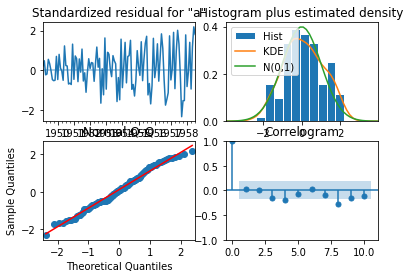

,predicted_mean
1958-09-01,496.695602
1958-10-01,499.738634
1958-11-01,498.183370
1958-12-01,498.978250
1959-01-01,498.571994
1959-02-01,498.779628
1959-03-01,498.673508
1959-04-01,498.727745
1959-05-01,498.700025
1959-06-01,498.714192


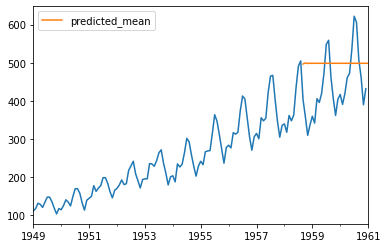

In [59]:
# Modelo 1
model_func5 = model_forecast(train_data2["air"], data["air"], 1,1,1, start=116, end=144)
model_func5

In [61]:
mse, rmse, mad, mape = evaluate_forecasts(test_data2["air"], model_func5)
results5 = pd.DataFrame([mse, rmse, mad, mape]).T
results5.columns = ["mse", "rmse", "mad", "mape"]
results5

,mse,rmse,mad,mape
0,9519.978337,9519.978337,85.528783,0.213489


+ Los errores son muy altos.
+ Los residuos tienen una distribución normal.
+ El modelo no logró captar la estacionalidad ni la tendencia de los datos.

                               SARIMAX Results                                
Dep. Variable:      rolling_mean_diff   No. Observations:                  115
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -129.377
Date:                Tue, 07 Feb 2023   AIC                            264.755
Time:                        11:36:05   BIC                            272.963
Sample:                    01-01-1949   HQIC                           268.086
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6461      0.307     -2.108      0.035      -1.247      -0.045
ma.L1          0.4616      0.344      1.343      0.179      -0.212       1.135
sigma2         0.6343      0.093      6.855      0.0

<Figure size 504x504 with 0 Axes>

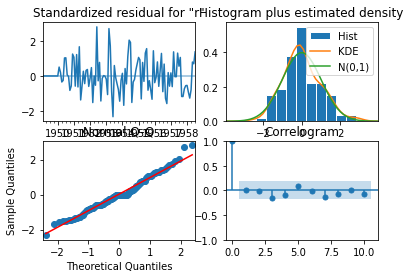

,predicted_mean
1958-09-01,2.098052
1958-10-01,2.017110
1958-11-01,2.069408
1958-12-01,2.035617
1959-01-01,2.057450
1959-02-01,2.043344
1959-03-01,2.052458
1959-04-01,2.046569
1959-05-01,2.050374
1959-06-01,2.047916


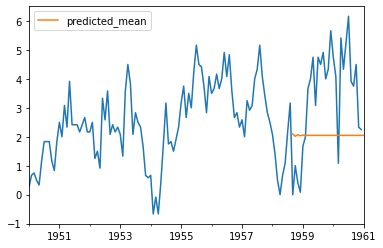

In [65]:
# Modelo 2: con los datos de la diferenciación
model_func6 = model_forecast(train_data2["rolling_mean_diff"], data["rolling_mean_diff"].dropna(), 1,1,1, start=116, end=144)
model_func6

In [66]:
mse, rmse, mad, mape = evaluate_forecasts(test_data2["rolling_mean_diff"], model_func6)
results6 = pd.DataFrame([mse, rmse, mad, mape]).T
results6.columns = ["mse", "rmse", "mad", "mape"]
results6

,mse,rmse,mad,mape
0,4.831024,4.831024,1.949463,3.132502e+14


+ El modelo no logró aprender bien de los datos de entrenamiento.
+ Los errores son muy altos.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26280D+00    |proj g|=  3.09266D-02

At iterate    5    f=  3.25399D+00    |proj g|=  2.63120D-02

At iterate   10    f=  3.25331D+00    |proj g|=  2.35063D-04

At iterate   15    f=  3.25331D+00    |proj g|=  6.40901D-05

At iterate   20    f=  3.25331D+00    |proj g|=  8.42926D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     25      1     0     0   8.429D-05   3.253D+00
  F =   3.2533052194696341     

CONVERG

<AxesSubplot:>

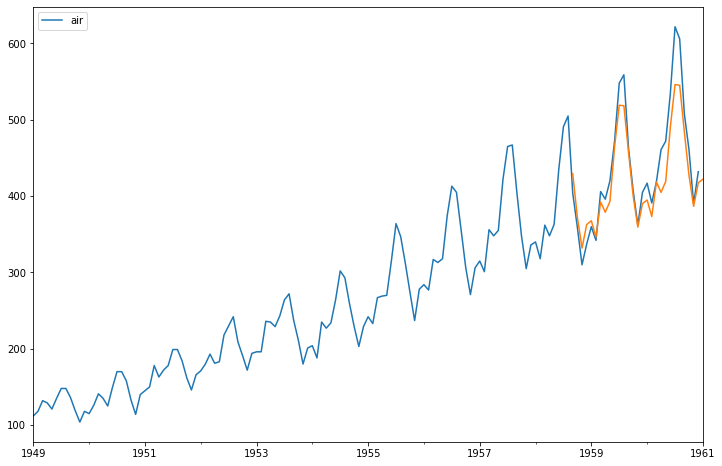

In [46]:
# Modelo 3: SARIMAX
sarimax = sm.tsa.statespace.SARIMAX(train_data2['air'], order=(1, 1, 1), seasonal_order=(1,1,1,12))
results = sarimax.fit()

forecast = results.predict(start=116,end=144)
data[['air']].plot(figsize=(12,8))
forecast.plot()

Ahora los datos de la predicción se parecen mucho más a los datos de prueba. Al modelo le faltó predecir el incremento en la varianza, pero el patrón estacional lo captó bien.

In [47]:
# Métricas de error
mse, rmse, mad, mape = evaluate_forecasts(test_data2['air'], forecast)
results4 = pd.DataFrame([mse, rmse, mad, mape]).T
results4.columns = ["mse", "rmse", "mad", "mape"]
results4

,mse,rmse,mad,mape
0,2612.660741,2612.660741,42.454298,0.093753


Los valores de las métricas de error son altas, pero el MAPE indica que en promedio el modelo solo tuvo 9% de error.

### Ejercicio 4
Realizar una predicción de 20 unidades de tiempo en el futuro, tanto para el modelo ARIMA como SARIMA y reportar los resulados en una gráfica donde se puedan observar los datos reales y los datos predichos, cómo en la siguiente gráfica:

#### ARIMA

                               SARIMAX Results                                
Dep. Variable:               WWWusage   No. Observations:                   80
Model:             ARIMA([2], 2, [2])   Log Likelihood                -204.918
Date:                Tue, 07 Feb 2023   AIC                            415.836
Time:                        11:28:45   BIC                            422.906
Sample:                             0   HQIC                           418.666
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.1580      0.299     -0.528      0.598      -0.744       0.428
ma.L2         -0.2139      0.299     -0.716      0.474      -0.799       0.372
sigma2        11.1660      2.019      5.531      0.0

<Figure size 504x504 with 0 Axes>

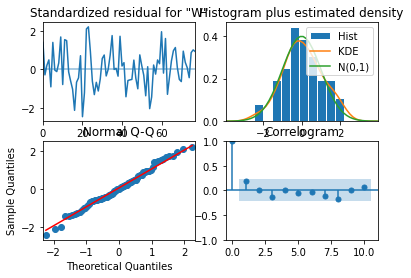

,predicted_mean
81,124.312021
82,131.192974
83,138.228424
84,145.230071
85,152.207315
86,159.189898
87,166.176336
88,173.161931
89,180.146916
90,187.132035


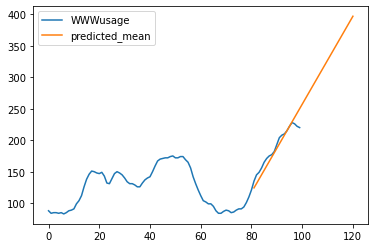

In [51]:
# Modelo 2 hecho en el ejercicio 1
model_forecast(train_data, df, (0,1),2,(0,1), start=81, end=100 + HORIZONTE)

#### SARIMA

In [52]:
# Predicción
pred_date=[data.index[-1]+ DateOffset(months=x)for x in range(0,12)]

In [53]:
pred_date = pd.DataFrame(index=pred_date[1:],columns=data.columns)
pred_date

,air,rolling_mean_diff
1961-01-01,NaN,NaN
1961-02-01,NaN,NaN
1961-03-01,NaN,NaN
1961-04-01,NaN,NaN
1961-05-01,NaN,NaN
1961-06-01,NaN,NaN
1961-07-01,NaN,NaN
1961-08-01,NaN,NaN
1961-09-01,NaN,NaN
1961-10-01,NaN,NaN


In [54]:
data2=pd.concat([data,pred_date])
data2

,air,rolling_mean_diff
1949-01-01,112,NaN
1949-02-01,118,NaN
1949-03-01,132,NaN
1949-04-01,129,NaN
1949-05-01,121,NaN
...,...,...
1961-07-01,NaN,NaN
1961-08-01,NaN,NaN
1961-09-01,NaN,NaN
1961-10-01,NaN,NaN


<AxesSubplot:>

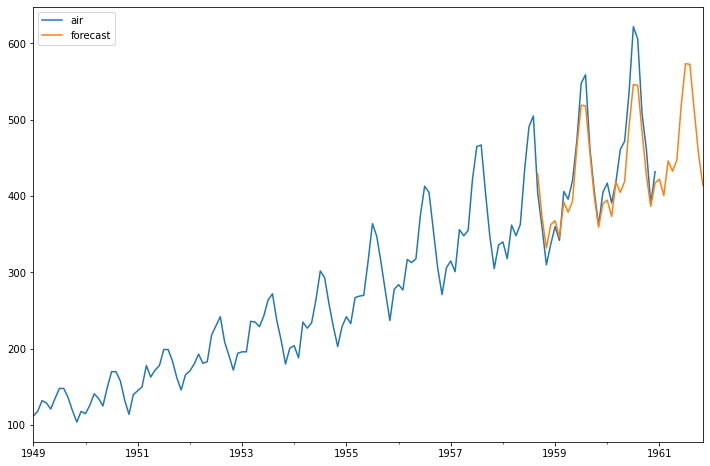

In [55]:
# Predicción a 20 unidades en el futuro
data2['forecast'] = results.predict(start=116,end=164, dynamic= True)
data2[['air', 'forecast']].plot(figsize=(12, 8))

## Conclusión
En los modelos ARIMA no logramos conseguir un modelo que siguiera el compoertamiento de los datos de entrenamiento, aunque captó una tendencia lineal. El mejor modelo tuvo un MAPE de 0.0392, lo cual considero que significa que el modelo se aceró bastante en los datos de prueba, sin embargo, al predecir 20 unidades en el futuro continuó con la predición hacia arriba.
El modelo SARMIX tuvo mejores resultados, captó bien la estacionalidad y la tendencia y obtuvo un MAPE de 0.09.